In [ ]:
from google.colab import files
files.upload()

!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58

In [ ]:
import pandas as pd
df = pd.read_csv("/content/styles_1.csv", on_bad_lines='skip')
apparels = df[df["masterCategory"] == "Apparel"]
apparels = apparels[(apparels.subCategory == "Topwear") | (apparels.subCategory=="Bottomwear") | (apparels.subCategory=="Dress") ]
apparels.drop(["masterCategory","year","gender","articleType","productDisplayName",],axis=1, inplace=True)
apparels.dropna(inplace=True)
apparels.loc[:,"image"] = apparels.apply(lambda row: str(row["id"]) + ".jpg", axis=1)
#apparels  = apparels.sample(frac=1).reset_index(drop=True)
apparels.dropna(inplace=True)
apparels.loc[(apparels.baseColour=="Red")|
             (apparels.baseColour=="Burgundy"),"colorgroup"] = "Red"
apparels.loc[(apparels.baseColour=="Brown")|
             (apparels.baseColour=="Coffee Brown")|
             (apparels.baseColour=="Maroon")|
             (apparels.baseColour=="Rust")|
             (apparels.baseColour=="Mushroom Brown"),"colorgroup"] = "Brown"
apparels.loc[(apparels.baseColour=="Copper")|
             (apparels.baseColour=="Orange")|
             (apparels.baseColour=="Bronze")|
             (apparels.baseColour=="Skin")|
             (apparels.baseColour=="Nude"),"colorgroup"] = "Orange"
apparels.loc[(apparels.baseColour=="Gold")|
             (apparels.baseColour=="Khaki")|
             (apparels.baseColour=="Beige")|
             (apparels.baseColour=="Mustard")|
             (apparels.baseColour=="Tan")|
             (apparels.baseColour=="Metallic")|
             (apparels.baseColour=="Yellow"),"colorgroup"] = "Yellow"
apparels.loc[(apparels.baseColour=="Lime Green")|
             (apparels.baseColour=="Green")|
             (apparels.baseColour=="Sea Green")|
             (apparels.baseColour=="Fluorescent Green")|
             (apparels.baseColour=="Olive"),"colorgroup"] = "Green"
apparels.loc[(apparels.baseColour=="Teal")|
             (apparels.baseColour=="Turquoise Blue")|
             (apparels.baseColour=="Blue")|
             (apparels.baseColour=="Navy Blue"),"colorgroup"] = "Blue"
apparels.loc[(apparels.baseColour=="Purple")|
             (apparels.baseColour=="Lavender"),"colorgroup"] = "Purple"
apparels.loc[(apparels.baseColour=="Pink")|
             (apparels.baseColour=="Magenta")|
             (apparels.baseColour=="Peach")|
             (apparels.baseColour=="Rose")|
             (apparels.baseColour=="Mauve"),"colorgroup"] = "Pink"
apparels.loc[(apparels.baseColour=="Black")|
             (apparels.baseColour=="Charcoal"),"colorgroup"] = "Black"
apparels.loc[(apparels.baseColour=="White")|
             (apparels.baseColour=="Off White")|
             (apparels.baseColour=="Cream"),"colorgroup"] = "White"
apparels.loc[(apparels.baseColour=="Grey")|
             (apparels.baseColour=="Silver")|
             (apparels.baseColour=="Taupe")|
             (apparels.baseColour=="Grey Melange"),"colorgroup"] = "Grey"
apparels.loc[(apparels.baseColour=="Multi"),"colorgroup"] = "Mixed"

apparels.baseColour = apparels.colorgroup
apparels.drop("colorgroup",axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras import regularizers

le = LabelEncoder()

apparels.loc[:,"color_id"]= le.fit_transform(apparels["baseColour"])
apparels.loc[:,"type_id"]= le.fit_transform(apparels["subCategory"])
apparels.loc[:,"season_id"]= le.fit_transform(apparels["season"])
apparels.loc[:,"usage_id"]= le.fit_transform(apparels["usage"])



In [ ]:
x_train , x_test = train_test_split(apparels,test_size=0.3)

color_colum = "color_id"
color_train = x_train[color_colum].to_numpy()
color_test = x_test[color_colum].to_numpy()

type_colum = "type_id"
type_train = x_train[type_colum].to_numpy()
type_test = x_test[type_colum].to_numpy()

season_colum = "season_id"
season_train = x_train[season_colum].to_numpy()
season_test = x_test[season_colum].to_numpy()

usage_colum = "usage_id"
usage_train = x_train[usage_colum].to_numpy()
usage_test = x_test[usage_colum].to_numpy()




In [ ]:
@tf.function
def load_image(image_path, label_dict):
  image = tf.io.read_file("/content/myntradataset/images/" + image_path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image,[80,60])
  image = image / 255.
  return (image, label_dict)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train["image"].tolist(),
                                                    {"type":type_train,
                                                     "color":color_train,
                                                     "usage":usage_train,
                                                     "season":season_train
                                                     }))

test_dataset = tf.data.Dataset.from_tensor_slices((x_test["image"].tolist(),
                                                  {"type":type_test,
                                                   "color":color_test,
                                                   "usage":usage_test,
                                                   "season":season_test
                                                   }))


SHUFFLE_VAL = len(x_train)
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(SHUFFLE_VAL).map(load_image).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.map(load_image).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(80,60,3),include_top=False, weights="imagenet")
#base_model.trainable = False

for layer in base_model.layers[:5]:
  layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
NUM_USAGE = len(apparels.usage_id.unique())
NUM_SEASON = len(apparels.season_id.unique())
NUM_COLOR = len(apparels.color_id.unique())
NUM_TYPE = len(apparels.type_id.unique())

input = layers.Input((80,60,3))

augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])
t = augment(input)
t = base_model(t,training=False)
t = layers.GlobalAveragePooling2D()(t)
t = layers.Dense(1024,activation="relu",kernel_regularizer="l2")(t)
t = layers.Dense(512,activation="relu")(t)
t = layers.Dense(256,activation="relu",kernel_regularizer="l2")(t)
t = layers.Dense(128,activation="relu")(t)
t = layers.Dense(64,activation="relu")(t)



color_outputs=layers.Dense(NUM_COLOR,activation="softmax",name="color")(t)
type_outputs=layers.Dense(NUM_TYPE,activation="softmax",name="type")(t)
usage_outputs=layers.Dense(NUM_USAGE,activation="softmax",name="usage")(t)
season_outputs=layers.Dense(NUM_SEASON,activation="softmax",name="season")(t)

model_1 = tf.keras.Model(inputs=input,outputs=[color_outputs,
                                               season_outputs,
                                               usage_outputs,
                                               type_outputs
                                               ]
                         )

initial_learning_rate = 1e-4
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #initial_learning_rate, decay_steps=1000, decay_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_1.compile(optimizer=optimizer,
                loss={"color":"sparse_categorical_crossentropy",
                      "type":"sparse_categorical_crossentropy",
                      "usage":"sparse_categorical_crossentropy",
                      "season":"sparse_categorical_crossentropy"
                      },
                metrics={"color": ["accuracy"],
                         "type": ["accuracy"],
                         "usage": ["accuracy"],
                         "season": ["accuracy"]
                         }
                )


In [ ]:
model_1.summary()

In [ ]:
tf.keras.utils.plot_model(model_1,show_shapes=True,show_layer_names=True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

In [ ]:
history_1 = model_1.fit(train_dataset,
                        epochs=35,
                        validation_data=test_dataset,
                        callbacks=[callback]
                        )

Epoch 1/35
203/203 [==============================] - 212s 953ms/step - loss: 14.9620 - color_loss: 1.6334 - season_loss: 0.8143 - usage_loss: 0.7198 - type_loss: 0.2258 - color_accuracy: 0.4670 - season_accuracy: 0.5888 - usage_accuracy: 0.7513 - type_accuracy: 0.9341 - val_loss: 11.8203 - val_color_loss: 1.3341 - val_season_loss: 0.8098 - val_usage_loss: 0.6090 - val_type_loss: 0.1728 - val_color_accuracy: 0.5706 - val_season_accuracy: 0.5884 - val_usage_accuracy: 0.7712 - val_type_accuracy: 0.9536
Epoch 2/35
203/203 [==============================] - 193s 951ms/step - loss: 9.9267 - color_loss: 1.2017 - season_loss: 0.7670 - usage_loss: 0.5419 - type_loss: 0.1344 - color_accuracy: 0.6129 - season_accuracy: 0.6263 - usage_accuracy: 0.8103 - type_accuracy: 0.9597 - val_loss: 8.5309 - val_color_loss: 1.1468 - val_season_loss: 0.7377 - val_usage_loss: 0.5273 - val_type_loss: 0.1229 - val_color_accuracy: 0.6246 - val_season_accuracy: 0.6441 - val_usage_accuracy: 0.8169 - val_type_accurac

In [ ]:
 model_1.evaluate(test_dataset)


87/87 [==============================] - 31s 346ms/step - loss: 2.2960 - color_loss: 0.8782 - season_loss: 0.6522 - usage_loss: 0.3320 - type_loss: 0.0733 - color_accuracy: 0.7324 - season_accuracy: 0.7486 - usage_accuracy: 0.8843 - type_accuracy: 0.9792


[2.2960405349731445,
 0.8781898617744446,
 0.6522001624107361,
 0.33198657631874084,
 0.07328333705663681,
 0.7323867678642273,
 0.7485621571540833,
 0.8842559456825256,
 0.9791516661643982]

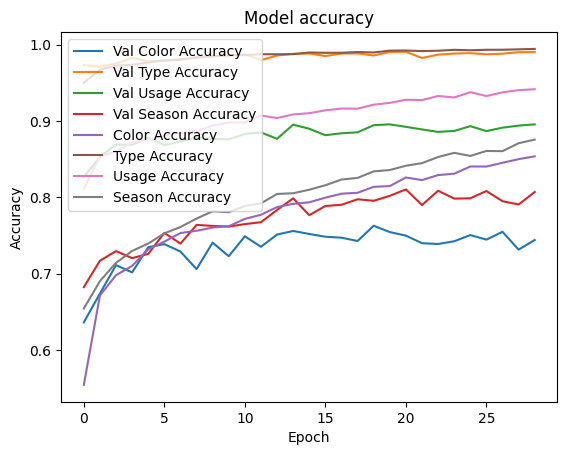

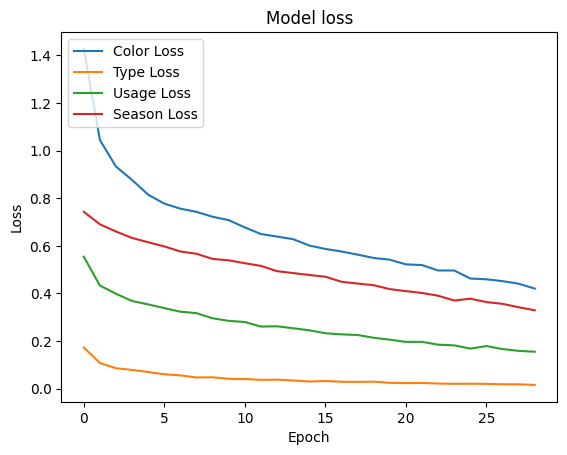

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_1.history['val_color_accuracy'])
plt.plot(history_1.history['val_type_accuracy'])
plt.plot(history_1.history['val_usage_accuracy'])
plt.plot(history_1.history['val_season_accuracy'])
plt.plot(history_1.history['color_accuracy'])
plt.plot(history_1.history['type_accuracy'])
plt.plot(history_1.history['usage_accuracy'])
plt.plot(history_1.history['season_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val Color Accuracy', 'Val Type Accuracy',"Val Usage Accuracy","Val Season Accuracy","Color Accuracy","Type Accuracy","Usage Accuracy","Season Accuracy"], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['color_loss'])
plt.plot(history_1.history['type_loss'])
plt.plot(history_1.history['usage_loss'])
plt.plot(history_1.history['season_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Color Loss', 'Type Loss','Usage Loss', 'Season Loss'], loc='upper left')
plt.show()

In [ ]:
model_1.save("model_1.h5")

In [ ]:
clr = ['Blue', 'Black', 'Grey', 'Green', 'Purple', 'White', 'Brown',
       'Pink', 'Yellow', 'Red', 'Orange', 'Mixed']
clr.sort()

ssn = ['Fall', 'Summer', 'Spring', 'Winter']
ssn.sort()

sbc = ['Topwear', 'Bottomwear', 'Dress']
sbc.sort()

usg = ['Casual', 'Ethnic', 'Formal', 'Sports', 'Smart Casual', 'Party','Travel']
usg.sort()

clr_dict = {i: clr[i] for i in range(len(clr))}
ssn_dict = {i: ssn[i] for i in range(len(ssn))}
sbc_dict = {i: sbc[i] for i in range(len(sbc))}
usg_dict = {i: usg[i] for i in range(len(usg))}

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("model_1.h5")

In [ ]:
img = tf.io.read_file("/content/*.jpg")
img = tf.image.decode_image(img, channels=3)
img = tf.image.resize(img,size= [80,60])
img = img/255.0

In [ ]:
prediction = model_1.predict(tf.expand_dims(img,axis=0))

1/1 [==============================] - 0s 35ms/step


In [ ]:
import numpy as np
clr_o = np.argmax(prediction[0])
ssn_o = np.argmax(prediction[1])
usg_o = np.argmax(prediction[2])
sbc_o = np.argmax(prediction[3])

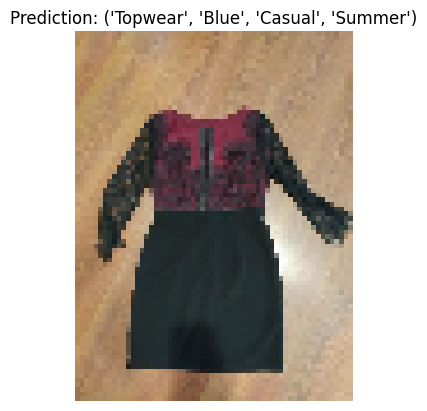

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Prediction: {sbc_dict[sbc_o],clr_dict[clr_o],usg_dict[usg_o],ssn_dict[ssn_o]}")
plt.axis(False);